In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from itertools import chain
from typing import List, Tuple
from pprint import pprint
from joblib import Parallel
from joblib import delayed
from IPython.display import Image

%matplotlib inline

# Agenda

1. [Data Preparation (in a short)](#Data_Preparation)
2. [Validation](#Validation)
3. [Reccurent Neural Networks (RNN, GRU, LSTM)](#Reccurent_Neural_Networks)
4. [Sentance Classification](#Sentance_Classification)
5. [Token Classification](#Token_Classification) 
6. [Homework](#Homework)

<a id='Data_Preparation'></a>
# Data Preparation

## Load 

In [2]:
os.listdir("../data/nlp_getting_started/")

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'Formalization_ML_Task_first_baseline.csv',
 'Recurrent_NNs_try1.csv',
 'Recurrent_NNs_try2.csv',
 'Recurrent_NNs_try3.csv',
 'Recurrent_NNs_try4.csv']

In [3]:
train = pd.read_csv("../data/nlp_getting_started/train.csv")
test = pd.read_csv("../data/nlp_getting_started/test.csv")
sample_submission = pd.read_csv("../data/nlp_getting_started/sample_submission.csv")

## Initial Exploration

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [7]:
train.shape, test.shape

((7613, 5), (3263, 4))

## Explore Targets

In [8]:
train["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
train["target"].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

## Text Preparation

### My Logic

1. Sample random texts
```python
train.sample(1).text.iloc[0]
```
2. Got `#what #tribal Olap #world pres: http://t.co/Jw6FNnsSxT How To Recognize A Hazardous Waste And The Multidimensi http://t.co/4zAzTB19qE`
3. Fix with
```python
def wise_text_cleaning(input):
    if isinstance(input, str):
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
    return input
```
4. Go back to step 1 and iterate

> **TODO**: Continue several loops

In [10]:
# Taken from https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#4.-Embeddings-and-Text-Cleaning
def wise_text_cleaning(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames part skipped
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # # Grouping same words without embeddings
    # tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    # tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

In [11]:
train["cleaned_text"] = train["text"].apply(wise_text_cleaning)
test["cleaned_text"] = test["text"].apply(wise_text_cleaning)

In [12]:
train

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ aria_ahrary @ TheTawniest The out of contr...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e - bike collide...


<a id='Validation'></a>
# Validation

In [13]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(train, train["target"])]

In [14]:
X_train_fold_0, X_test_fold_0 = train.iloc[folds_train_test_ids[0][0]], train.iloc[folds_train_test_ids[0][1]]
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [15]:
print("Test Target distribution")
X_test_fold_0["target"].value_counts(normalize=True)

Test Target distribution


target
0    0.569928
1    0.430072
Name: proportion, dtype: float64

In [16]:
print("Train Target distribution")
X_train_fold_0["target"].value_counts(normalize=True)

Train Target distribution


target
0    0.570443
1    0.429557
Name: proportion, dtype: float64

In [17]:
def comp_metric(y_true, y_pred, tresh=None):
    assert y_true.shape == y_pred.shape
    if tresh is not None:
        y_pred = y_pred > tresh
    return f1_score(y_true, y_pred, average='macro')

In [18]:
print("Check Metric on all Correct")
print(
    comp_metric(train["target"], train["target"]), 
    comp_metric(train["target"], train["target"], tresh=0.5)
)
print("Check Metric on all NOT Correct")
print(
    comp_metric(train["target"], (train["target"] - 1).abs()), 
    comp_metric(train["target"], (train["target"] - 1).abs(), tresh=0.5) 
)

Check Metric on all Correct
1.0 1.0
Check Metric on all NOT Correct
0.0 0.0


<a id='Reccurent_Neural_Networks'></a>
# Reccurent Neural Networks (RNN, GRU, LSTM)

## Artificial Neural Network (ANN)
* It is also called deep neural network or deep learning.
* **What is neural network:** It is basically taking logistic regression and repeating it at least 2 times.
* In logistic regression, there are input and output layers. However, in neural network, there is at least one hidden layer between input and output layer.
* **What is deep, in order to say "deep" how many layer do I need to have:** ...
* **Why is it called hidden:** Because hidden layer does not see inputs(training set): For example you have input, one hidden and output layers. When someone ask you "hey my friend how many layers do your neural network have?" The answer is "I have 2 layer neural network". Because while computing layer number input layer is ignored. 
* Let's see 2 layer neural network: 
<a href="http://ibb.co/eF315x"><img src="http://preview.ibb.co/dajVyH/9.jpg" alt="9" border="0"></a>
* We will learn this image step by step.
    * As you can see, one hidden layer exists between the input and output layers. This layer has 3 nodes. If you are curious why I chose 3 as the number of nodes, the answer is "There is no reason." I simply choose :). The number of nodes is a hyperparameter, like the learning rate.
    * Input and output layers do not change. They are the same as logistic regression.
    * In the image, there is a tanh function. It is an activation function like the sigmoid function. The tanh activation function is better than sigmoid for hidden units because the mean of its output is closer to zero, so it centers the data better for the next layer. Also, the tanh activation function increases non-linearity, which causes our model to learn better.
    * As you can see, there are two notable parts outlined in purple. Both are like logistic regression. The only difference is the activation function, inputs, and outputs:
        * In logistic regression: input => output.
        * In 2-layer neural network: input => hidden layer => output. You can treat the hidden layer as an output of part 1 and an input of part 2.
* That's all. We will follow the same path as logistic regression for a two-layer neural network.
   
    
    

<a id="7"></a> <br>
##  Optimization Algorithm with Gradient Descent
* Cost function (or loss function) that is an error.
* Therefore, we need to decrease cost because, as we know, if the cost is high, we make a wrong prediction.
* Let's think about the first step. Everything starts with initializing weights and bias. Therefore, cost is dependent on them.
* To decrease cost, we need to update weights and bias.
* In other words, our model needs to learn the parameters (weights and bias) that minimize the cost function. This technique is called gradient descent.
* Let's make an example:
    * We have $w = 5$ and $bias = 0$ (so we can ignore bias for now). Then, we make a forward propagation, and our cost function is 1.5.
    * It looks like this (highlighted with red lines). 
    <a href="http://imgbb.com/"><img src="http://image.ibb.co/dAaYJH/7.jpg" alt="7" border="0"></a>
    * As you can see from the graph, we are not at the minimum point of the cost function. Therefore, we need to go through minimum cost. Okay, let's update the weight (the symbol ":=" means updating). 
    * $w := w - step$. The question is, what is this step? The step is $slope_1$. Okay, it looks remarkable. To find the minimum point, we can use $slope_1$. Then let's say $slope_1 = 3$ and update our weight. $w := w - slope_1 \implies w = 2$.
    * Now, our weight $w$ is $2$. As you remember, we need to find the cost function with forward propagation again. 
    * Let's say according to forward propagation with $w = 2$, cost function is 0.4. Hmm, we are in the right way because our cost function is decreasing. We have a new value for the cost function, so that $cost = 0.4$. Is that enough? Actually, I do not know. Let's try one more step.
    * $slope_2 = 0.7$ and $w = 2$. Let's update weight $w : = w - slope_2 \implies w = 1.3$, that is the new weight. So let's find a new cost.
    * Make one more forward propagation with $w = 1.3$ and our $cost = 0.3$. Okay, our cost decreased even further; it looks fine, but is it enough, or do we need to make one more step? The answer is, again, "I do not know; let's try."
    * $slope_3 = 0.01$ and $w = 1.3$. Updating weight $w := w - slope_3 \implies w = 1.29 \approx 1.3$. So, the weight does not change significantly because we find the minimum point of the cost function. 
    * Everything looks good, but how do we find the slope? If you remember from high school or university, to find the slope of a function (cost function) at a given point (at a given weight), we take the function's derivative at a given point. Also, you can ask, "Okay, well, we have found the slope, but how does it know where to go?" It can go to higher cost values instead of the minimum point. The answer is that slope (derivative) gives both the step and direction of the step. Therefore, do not worry :)
    * Update equation looks like this. It says there is a cost function (takes weight and bias). Take the derivative of the cost function according to weights and bias. Then multiply it with a learning rate α. Then, update weights. (I ignore bias here, but this algorithm also fully applies).
    <a href="http://imgbb.com/"><img src="http://image.ibb.co/hYTTJH/8.jpg" alt="8" border="0"></a>
    * Now, I am sure you are asking, "What is a learning rate you have never mentioned." It is a straightforward term that determines the learning rate. However, there is a tradeoff between learning fast and learning never. For example, you are in Paris (current cost) and want to go to Madrid (minimum cost). If your speed (learning rate) is small, you can go to Madrid very slowly, which takes too long. On the other hand, if your speed (learning rate) is big, you can go very fast, but you may crash and never go to Madrid. Therefore, we need to choose wisely our speed (learning rate).
    * Learning rate is also called a hyperparameter that needs to be chosen and tuned.

## Recurrent Neural Networks

In a recurrent neural network, we store the output activations from one or more of the layers of the network. Often, these are hidden layer activations. Then, the next time we feed an input example to the network, we include the previously stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the "normal" inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer's outputs into itself rather than into another layer). Of course, the very first time you try to compute the network output, you'll need to fill in those extra 128 inputs with 0s or something.

Source: [Quora](https://www.quora.com/What-is-a-simple-explanation-of-a-recurrent-neural-network).

<img src="https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png">

Source: [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9).

Let me give you the best explanation of Recurrent Neural Networks I found online: https://www.youtube.com/watch?v=UNmqTiOnRfg&t=3s.

Now, even though RNNs are pretty powerful, they suffer from the **Vanishing gradient problem**, which hinders them from using long-term information. For instance, they are suitable for storing memory 3-4 instances of past iterations, but a larger number of instances don't provide good results. So, we don't use just regular RNNs. Instead, we use a better variation of RNNs: **Long Short-Term Networks (LSTMs)**.

### What is Vanishing Gradient problem?

The vanishing gradient problem is a difficulty in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each training iteration. The problem is that, in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This fact has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n, resulting in the slow training of the front layers.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

<img src="https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png">

Source: [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257).


> **TODO**: Can you explain **Vanishing gradient problem** mathematically? 

## Long Short Term Memory(LSTM)

**Long short-term memory (LSTM)** units (or blocks) are building blocks for layers of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network. A common LSTM unit comprises a cell, an input gate, an output gate, and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought of as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression "long short-term" refers to the fact that LSTM is a model for short-term memory that can last for a long time. An LSTM is well-suited to classify, process, and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory).

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968).

The best LSTM explanation on the internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235.

Refer to the above link for deeper insights.

LSTM is not the only kind of unit that has taken the world of Deep Learning by storm. We have **Gated Recurrent Units (GRU)**. It's yet to be determined which is better, GRU or LSTM because they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units (GRU)

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly make use of all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. The reset gate determines how to combine new input with previous memory, and the update gate determines how much of the previous state to keep. The update gate in GRU is what the input and forget gates were in LSTM. We don't have the second non-linearity in GRU before calculating the output, nor do they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train).

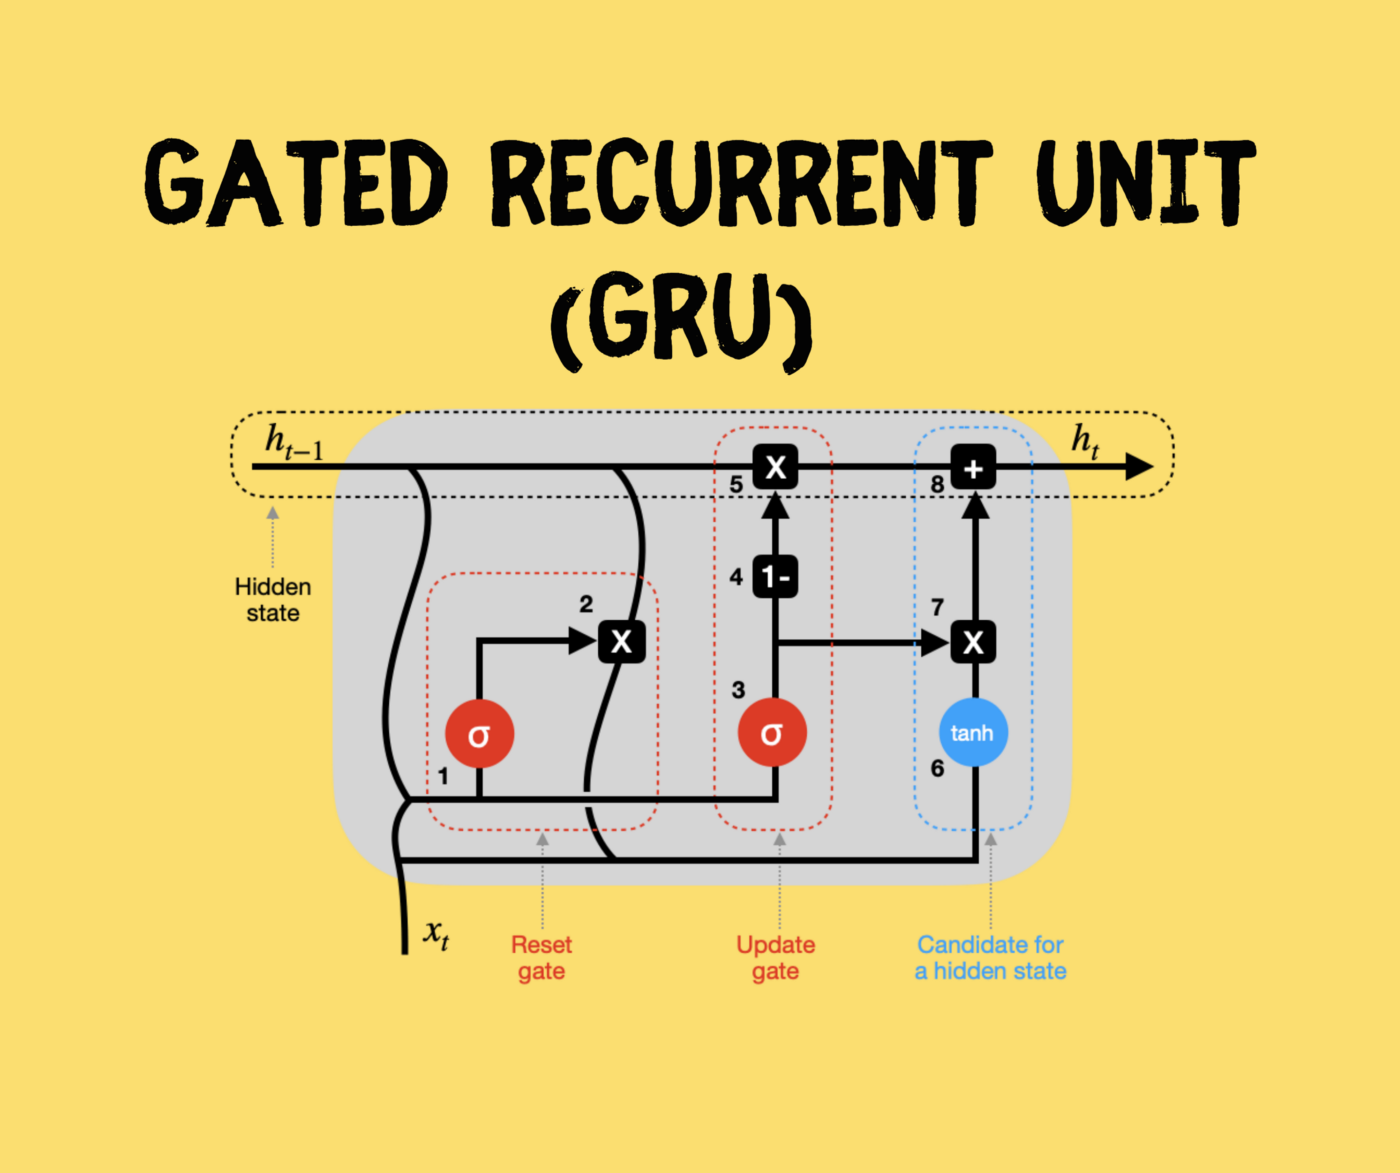

In [19]:
torch.manual_seed(42)
torch.backends.cuda.deterministic = True

if torch.cuda.is_available():
    global_device = "cuda"
else:
    global_device = "cpu"
print("Training device:", global_device)

Training device: cuda


<a id='Short_Explanation_what_is_nn_Embedding'></a>
## Short Explanation of what is nn.Embedding

Assume we want to build our own Word Embeddings. How can we do it?

1. Tokenize text - split it into separate entities (words and symbols).
2. Build Vocabulary (recall Bag of Words). So now we can assign some int (long) number to each word.
3. Construct some random matrix with dimension $vocab\_size \times embedding\_dimension$.
4. Now, we can take a particular vector from the built matrix for each word.

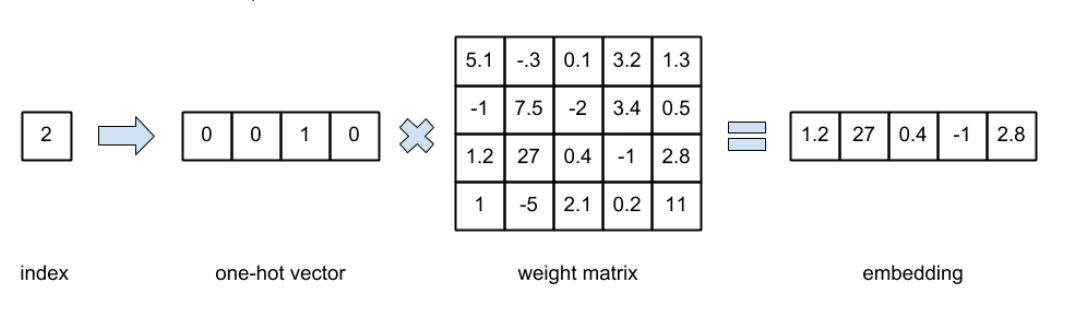

In [93]:
Image("images/Screenshot from 2023-10-16 12-53-17.png")

Here is the full pipeline

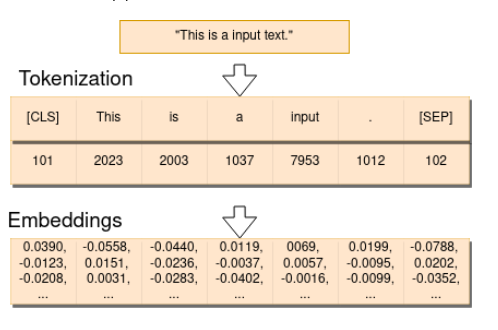

In [94]:
Image("images/Screenshot from 2023-10-16 12-53-30.png")

This matrix consists of trainable parameters and will be optimized during training.

> **TODO**: read about special tokens : `<CLS>`, `<SEP>`.

In [20]:
# Lets build or RNN Class 

class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None,
        dropout_rate=0.4
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        # TODO: What is bidirectional ? Try unidirectional
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(
                rnn_channels * 2 if bidirectional else rnn_channels, 
                out_channels, 
            )
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x
        
        

> **TODO**: What is bidirectional ? Try unidirectional

> **TODO**: Read about Dropout: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [21]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=1024, out_features=2, bias=True)
  )
)

<a id='Sentance_Classification'></a>
# Sentence Classification

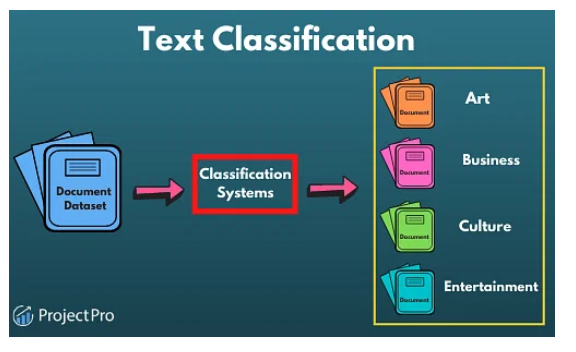

In [95]:
Image("images/Screenshot from 2023-10-16 12-53-47.png")

In [22]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [23]:
# Shape: Batch size, Time Dimension 
random_input = torch.randint(low=0, high=128, size=(2, 128))
random_input.shape

torch.Size([2, 128])

In [24]:
# Token Classification Example
nn_model(random_input).shape

torch.Size([2, 128, 2])

In [25]:
nn_model = UniversalRNN(128, 2, average_type="mean")
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [26]:
# Text Classification Example
nn_model(random_input).shape

torch.Size([2, 2])

## Go Deeper in [PyTorch](https://pytorch.org/docs/stable/index.html)

### [Pytorch Dataset and Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) + [torchtext](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

In [27]:
# Select Tokenization algorithm: check Short_Explanation_what_is_nn_Embedding step 1
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build Vocabulary: check Short_Explanation_what_is_nn_Embedding step 2
vocab = build_vocab_from_iterator(
    yield_tokens(train["cleaned_text"]), 
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [28]:
vocab_with_freq = pd.Series(list(chain(*list(yield_tokens(train["cleaned_text"]))))).value_counts()
vocab_with_freq

.              6979
#              3403
the            3282
?              3126
@              2759
               ... 
cnv               1
vigils            1
davidvitter       1
2003              1
symptoms          1
Name: count, Length: 17076, dtype: int64

> **TODO**: Read [Vocab Docs](https://pytorch.org/text/stable/vocab.html). Maybe you can figure out how to extract token frequencies better.

In [29]:
vocab.lookup_indices(["#wildfires", "wildfires", "<unk>", "<pad>"])

[0, 1599, 0, 1]

In [30]:
vocab.lookup_tokens([0, 1599, 0, 1])

['<unk>', 'wildfires', '<unk>', '<pad>']

In [31]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        pad_token_id=1,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        self.pad_token_id = pad_token_id
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequence(self, input):
        if len(input) < self.max_length:
            return input + [self.pad_token_id] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequence(text_ids)
        text_target = self.targets[idx]
        # Why did I do so ???
        if not isinstance(text_target, (list, np.ndarray)):
            text_target = np.array([text_target])
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(text_target).float()
        )
    
    def __len__(self):
        return len(self.texts)

> **TODO**: Read More - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset.

> **TODO**: Is it a best solution? Read about collate_fn - https://pytorch.org/docs/stable/data.html.

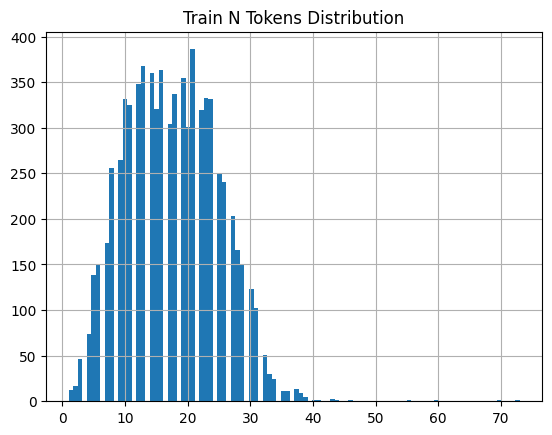

0.95 Quantile of N tokens: 30.0


In [32]:
# Here we want to figure out empirically max_length

train_n_tokens = train["cleaned_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [33]:
SEQ_LEN = 50

> **TODO**: Try to propose another ways to do it.

In [34]:
train_torch_dataset = TextDataset(
    texts=train["cleaned_text"].to_list(),
    targets=train["target"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    # trim_policy="first"
)

In [35]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: Three people died from the heat wave so far
Text Ids: tensor([603,  70, 658,  31,   4, 290, 494,  47, 659,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1])
Target: tensor([1.])
Text Ids length: 50


In [36]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[   29,    15,     7,    72,  1169,  1769,    22,     7,   148,   566,
            63,    15,    29,     3,  3279,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    6,  8330, 16070,    48,   305,   974,     4,  1143,    19,   193,
           412,   295,     4,  1143,     9,    61,  1157,     2,  2876,   485,
          1853,    19,    21,  3621,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    6, 16226,   193,     2,    89,   114,   425,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,

### PyTorch Train and Validation loop 

In [37]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # 2. Compute Backward path
                loss.mean().backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

> **TODO**: Read about `train` and `eval` modes on official Torch Docs. What do they change?

> **TODO**: Is a mean a best choice?

> **TODO**: Try gradient clipping.

In [38]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=128,
    out_channels=1,
    average_type="mean",
    bidirectional=True
).to(global_device)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

> **TODO**: Read more about different loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions.

> **TODO**: Read more about optimizers: https://pytorch.org/docs/stable/optim.html.

> **TODO**: Try to tune hyperparameters here.

> **TODO**: Read more about schedulers: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate.

In [39]:
train_torch_dataset = TextDataset(
    texts=train.iloc[folds_train_test_ids[0][0]]["cleaned_text"].to_list(),
    targets=train.iloc[folds_train_test_ids[0][0]]["target"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    # It is highly important to shuffle data while training. Why?
    shuffle=True,
    # It is important to drop last batch while training. Why?
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=train.iloc[folds_train_test_ids[0][1]]["cleaned_text"].to_list(),
    targets=train.iloc[folds_train_test_ids[0][1]]["target"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

> **TODO**: Read more about DataLoader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [40]:
n_epochs = 20

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_metrics = []
train_metrics = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    train_metric = comp_metric(
        train_epoch_targets, 
        train_epoch_labels,
        tresh=0.5
    )
    print("Train metric:", train_metric)
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels,
        tresh=0.5
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric)
    # 4. Save best model
    if valid_metric > best_metric:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_metrics.append(valid_metric)
    train_metrics.append(train_metric)
    
        

Starting Epoch 1
Train phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:02<00:00, 89.89it/s]


Train metric: 0.6004731239321857
Train BCE loss: 0.6271138
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 66.05it/s]


Valid metric: 0.7324700693160004
Valid BCE loss: 0.5298091
Starting Epoch 2
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 120.25it/s]


Train metric: 0.7734868129196237
Train BCE loss: 0.47562915
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 64.74it/s]


Valid metric: 0.7603777874786277
Valid BCE loss: 0.47888303
Starting Epoch 3
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 103.56it/s]


Train metric: 0.8416849822146389
Train BCE loss: 0.3696053
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 51.37it/s]


Valid metric: 0.7735320142603804
Valid BCE loss: 0.4814752
Starting Epoch 4
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 118.52it/s]


Train metric: 0.8891205962318859
Train BCE loss: 0.2790153
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 67.48it/s]


Valid metric: 0.7689783276109508
Valid BCE loss: 0.5132805
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 5
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 116.72it/s]


Train metric: 0.9319435656408118
Train BCE loss: 0.18915159
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 68.99it/s]


Valid metric: 0.7684471581653571
Valid BCE loss: 0.6129447
Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
Starting Epoch 6
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 117.60it/s]


Train metric: 0.9540748720435782
Train BCE loss: 0.13582739
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 66.74it/s]


Valid metric: 0.7681326607381828
Valid BCE loss: 0.66376805
Epoch 00006: reducing learning rate of group 0 to 1.2500e-04.
Starting Epoch 7
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 124.48it/s]


Train metric: 0.9625088286575474
Train BCE loss: 0.110557124
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 72.56it/s]


Valid metric: 0.7546258351394456
Valid BCE loss: 0.71937203
Epoch 00007: reducing learning rate of group 0 to 6.2500e-05.
Starting Epoch 8
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 119.27it/s]


Train metric: 0.9672797605989863
Train BCE loss: 0.09825716
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 62.84it/s]


Valid metric: 0.7575338085903476
Valid BCE loss: 0.7431717
Epoch 00008: reducing learning rate of group 0 to 3.1250e-05.
Starting Epoch 9
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 117.11it/s]


Train metric: 0.970142229759171
Train BCE loss: 0.091356255
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 64.18it/s]


Valid metric: 0.7546109119339592
Valid BCE loss: 0.7595202
Epoch 00009: reducing learning rate of group 0 to 1.5625e-05.
Starting Epoch 10
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 120.69it/s]


Train metric: 0.9696410149887502
Train BCE loss: 0.08836726
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 63.08it/s]


Valid metric: 0.7540817282795826
Valid BCE loss: 0.7670714
Epoch 00010: reducing learning rate of group 0 to 7.8125e-06.
Starting Epoch 11
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 108.14it/s]


Train metric: 0.9711696514660765
Train BCE loss: 0.08689053
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 70.65it/s]


Valid metric: 0.7554218823489038
Valid BCE loss: 0.7723907
Epoch 00011: reducing learning rate of group 0 to 3.9063e-06.
Starting Epoch 12
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 125.79it/s]


Train metric: 0.9720111671361054
Train BCE loss: 0.08515898
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 69.63it/s]


Valid metric: 0.7554218823489038
Valid BCE loss: 0.7740655
Epoch 00012: reducing learning rate of group 0 to 1.9531e-06.
Starting Epoch 13
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 120.49it/s]


Train metric: 0.9718499719056974
Train BCE loss: 0.085367724
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 70.61it/s]


Valid metric: 0.7554218823489038
Valid BCE loss: 0.7752144
Epoch 00013: reducing learning rate of group 0 to 9.7656e-07.
Starting Epoch 14
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 118.11it/s]


Train metric: 0.9730228116974509
Train BCE loss: 0.08545995
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 67.58it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.7758327
Epoch 00014: reducing learning rate of group 0 to 4.8828e-07.
Starting Epoch 15
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 125.03it/s]


Train metric: 0.9709964565400029
Train BCE loss: 0.08596507
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 64.53it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.77612144
Epoch 00015: reducing learning rate of group 0 to 2.4414e-07.
Starting Epoch 16
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 119.35it/s]


Train metric: 0.9725299816496041
Train BCE loss: 0.0848685
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 64.99it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.7762312
Epoch 00016: reducing learning rate of group 0 to 1.2207e-07.
Starting Epoch 17
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 123.54it/s]


Train metric: 0.9710056334066917
Train BCE loss: 0.08532634
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 68.19it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.776287
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
Starting Epoch 18
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 114.16it/s]


Train metric: 0.9726942201768023
Train BCE loss: 0.08473368
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 69.69it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.77633625
Starting Epoch 19
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 118.95it/s]


Train metric: 0.9715188153299577
Train BCE loss: 0.08401084
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 66.71it/s]


Valid metric: 0.7547983023827873
Valid BCE loss: 0.7764047
Starting Epoch 20
Train phase


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 121.50it/s]


Train metric: 0.9721870979906593
Train BCE loss: 0.08457326
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 65.67it/s]

Valid metric: 0.7554218823489038
Valid BCE loss: 0.7764606


> **TODO**: Read [this article](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) about sample, batch, and epoch differences.

> **TODO**: Try to train for longer.

> **TODO**: Is 0.5 an optimal threshold?

Best Val F1: 0.7735320142603804


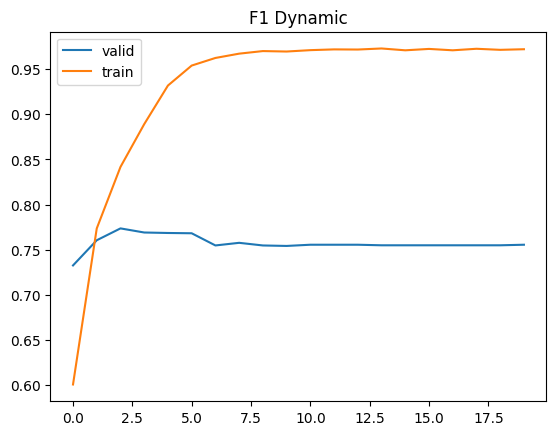

In [41]:
print("Best Val F1:", best_metric)
plt.title("F1 Dynamic")
plt.plot(valid_metrics, label="valid")
plt.plot(train_metrics, label="train")
plt.legend()
plt.show()

In [42]:
# Create Fake Target in test
test["target"] = 0

In [43]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=test["cleaned_text"].to_list(),
    targets=test["target"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=global_device,
    mode="eval"
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 130.59it/s]


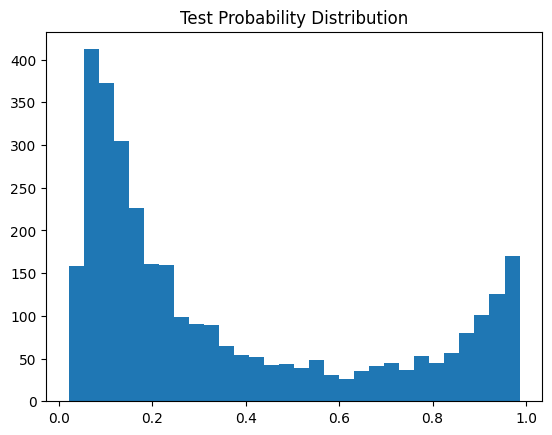

In [44]:
plt.title("Test Probability Distribution")
plt.hist(test_labels[:,0], bins=30)
plt.show()

In [45]:
sample_submission["target"] = (test_labels[:,0] > 0.5).astype(np.int32)
sample_submission["target"].value_counts()

target
0    2326
1     937
Name: count, dtype: int64

In [46]:
sample_submission.to_csv(
    "../data/nlp_getting_started/Recurrent_NNs_try4.csv", 
    index=False
)

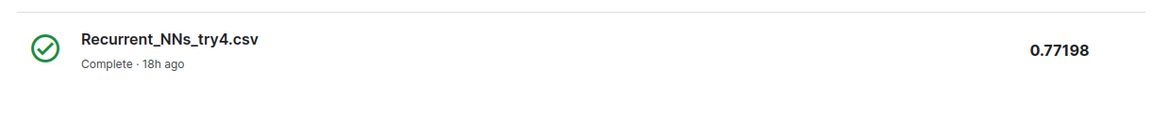

In [98]:
Image("images/Screenshot from 2023-10-16 12-54-11.png")

> **TODO**: Is my validation good here?

> **TODO**: What conclusions can we make from the "probability" distribution plot?

## Comparing Reccurent Nets to Bag of Words + Regression

**Pros:**
+ Shows better performance in terms of metrics (if hyperparameters are tuned and the model is not overfitted).
+ Take into account context.
+ Requires less text preprocessing.

**Cons:**
- Harder to implement.
- Harder to deploy.
- Requires GPU, at least for training.
- Requires more powerful clusters for inference.
- Works longer.
- Lacks interpretability.

<a id='Token_Classification'></a>
# Token Classification


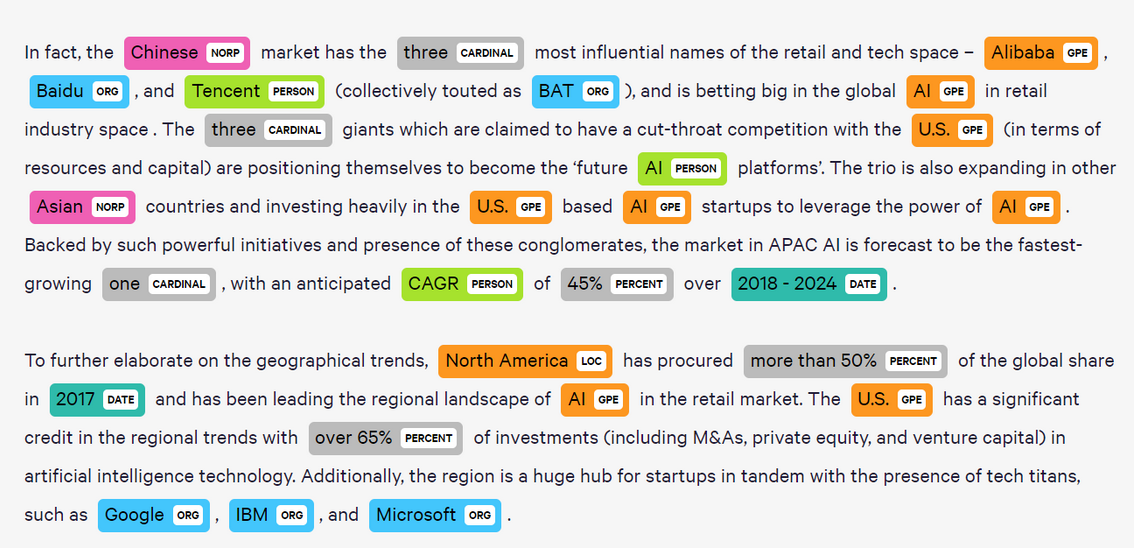

In [97]:
Image("images/Screenshot from 2023-10-16 12-54-26.png")

## Task Description 

Build a model that can take some text as input and return all unique locations from the text.

Example:

```
H("Їздив Гриць в Київ і був на Хрещатику. На Хрещатику Грицю дуже сподобалось") = {"Київ", "Хрещатику"}
```

## Data

### uk_geo_dataset
Ukrainian dataset [Corpora Ukrainian](https://huggingface.co/datasets/ukr-models/Ukr-Synth).
It contains approximately 1M text samples with location and organization entities.

Structure:
- text (str): text sample.
- loc_markers (List[tuple]): list of markers of location entities. Left and right indices.
- org_markers (List[tuple]): list of markers of origanization entities. Left and right indices.
- per_markers (List[tuple]): list of markers of person entities. Left and right indices.

### ru_geo_dataset
russian dataset based on [nerus dataset](https://github.com/natasha/nerus).
It contains approximately 8M text samples with location and organization entities.

Structure:
- text (str): text sample.
- loc_markers (List[tuple]): list of markers of location entities. Left and right indices.
- org_markers (List[tuple]): list of markers of origanization entities. Left and right indices.
- per_markers (List[tuple]): list of markers of person entities. Left and right indices.

## Proposed Metric

Micro F1 Score = 2 * (precision * recall) / (precision + recall)

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Definitions:
- TP: locations that are both in predicted set and real set.
- FP: locations that are in predicted set and NOT in real set.
- FN: locations that are NOT in predicted set and in real set.

So, to get final metric results, you have to compute for each data sample TP, FP, and FN separately and then accumulate them. Compute final precision, recall, and F1 after that.

## Train/Val/Test Split

Train and Val splits are up to you.

Hidden test set is currently in labeling process and will be used for final decision making.

## Production Use Case

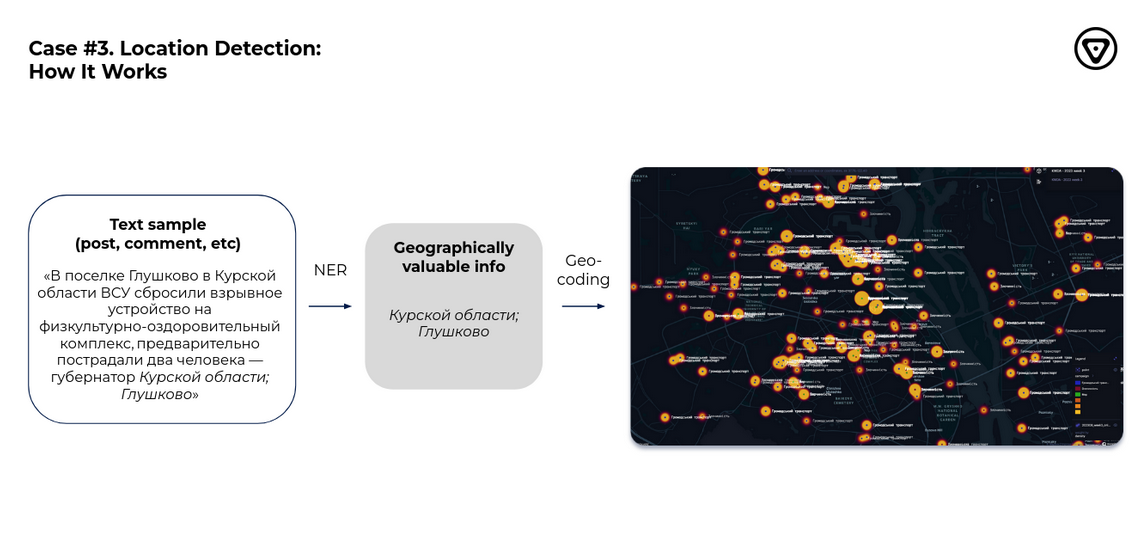

In [99]:
Image("images/Screenshot from 2023-10-16 12-54-33.png")

## Data Preparation

In [47]:
os.listdir("../data/mantis_analytics_location_detection/")

['README.md',
 'ru_geo_dataset.csv',
 'uk_geo_dataset.csv',
 'dataset-metadata.json',
 'uk_geo_dataset_processed_v1.parquet']

In [48]:
# ru_geo_dataset = pd.read_csv("../data/mantis_analytics_location_detection/ru_geo_dataset.csv", converters={"loc_markers": eval})
uk_geo_dataset = pd.read_csv("../data/mantis_analytics_location_detection/uk_geo_dataset.csv", converters={"loc_markers": eval})

In [49]:
# ru_geo_dataset

In [50]:
uk_geo_dataset

,text,loc_markers,org_markers,per_markers
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[]
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]"
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[]
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[]
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[]
...,...,...,...,...
1009995,"Траєкторія польоту цих літаків є провокуючою”,...",[],[],"[(56, 63)]"
1009996,Якщо порівняти у відсотковому співвідношенні к...,[],[],[]
1009997,"У інфікувалися четверо жінок, наймолодшій із н...",[],[],[]
1009998,"Хочу запевнити, що створення Православної Церк...",[],"[(29, 56)]",[]


In [51]:
uk_geo_dataset["language"] = "ukr"

# ru_geo_dataset["language"] = "rus"
# geo_dataset = pd.concat([ru_geo_dataset, uk_geo_dataset]).reset_index(drop=True)

geo_dataset = uk_geo_dataset

> **Explore**: It is not a standard NER format. Read: https://simpletransformers.ai/docs/ner-data-formats/.

> **Explore**: Is the proposed format "equal" to the CoNLL format? "Equal" means that we can transform between formats without losing any information.

## A bit of Data Exploration

In [52]:
print("Number of data points:", geo_dataset.shape[0])
geo_dataset["language"].value_counts()

Number of data points: 1010000


language
ukr    1010000
Name: count, dtype: int64

In [53]:
geo_dataset["number_of_locations"] = geo_dataset["loc_markers"].apply(len)

In [54]:
print("Distribution of No/(At least one) Location")
(geo_dataset["number_of_locations"] == 0).value_counts()

Distribution of No/(At least one) Location


number_of_locations
True     776579
False    233421
Name: count, dtype: int64

In [55]:
print("Distribution of Number of locations")
geo_dataset["number_of_locations"].value_counts()

Distribution of Number of locations


number_of_locations
0     776579
1     161061
2      48937
3      14815
4       4907
5       1979
6        842
7        401
8        219
9        127
10        71
11        35
12        15
13         5
16         3
21         1
19         1
15         1
14         1
Name: count, dtype: int64

## Validation

In [56]:
geo_dataset["stratify_col"] = geo_dataset["number_of_locations"]
geo_dataset.loc[geo_dataset["number_of_locations"] >= 14, "stratify_col"] = -1 

In [57]:
geo_dataset["stratify_col"].value_counts()

stratify_col
 0     776579
 1     161061
 2      48937
 3      14815
 4       4907
 5       1979
 6        842
 7        401
 8        219
 9        127
 10        71
 11        35
 12        15
-1          7
 13         5
Name: count, dtype: int64

In [58]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(geo_dataset, geo_dataset["stratify_col"])]

In [59]:
X_train_fold_0, X_test_fold_0 = geo_dataset.iloc[folds_train_test_ids[0][0]], geo_dataset.iloc[folds_train_test_ids[0][1]]
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [60]:
print("Test stratify_col distribution")
X_test_fold_0["stratify_col"].value_counts(normalize=True)

Test stratify_col distribution


stratify_col
 0     0.768891
 1     0.159465
 2     0.048455
 3     0.014668
 4     0.004856
 5     0.001960
 6     0.000837
 7     0.000396
 8     0.000213
 9     0.000129
 10    0.000069
 11    0.000035
 12    0.000015
 13    0.000005
-1     0.000005
Name: proportion, dtype: float64

In [61]:
print("Train stratify_col distribution")
X_train_fold_0["stratify_col"].value_counts(normalize=True)

Train stratify_col distribution


stratify_col
 0     0.768890
 1     0.159467
 2     0.048452
 3     0.014668
 4     0.004859
 5     0.001959
 6     0.000833
 7     0.000397
 8     0.000218
 9     0.000125
 10    0.000071
 11    0.000035
 12    0.000015
-1     0.000007
 13    0.000005
Name: proportion, dtype: float64

In [62]:
def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
        p += len(set(y_true_sample))

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)
        
    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

> **TODO**: Optimize it to handle a case of zero denominator.

In [63]:
sample_1000 = geo_dataset.iloc[:1000].apply(lambda row: [row["text"][left_id:right_id] for left_id,right_id in row["loc_markers"]], axis=1)

In [64]:
print("Examples of locations")
pd.Series(list(chain(*sample_1000))).value_counts()

Examples of locations


України                     20
Україні                     17
США                         10
Україна                      9
Росія                        8
                            ..
Будапешт                     1
Шулявським шляхопроводом     1
Одеси                        1
Деснянському районі          1
Російської Федерації         1
Name: count, Length: 219, dtype: int64

In [65]:
print("All correct case")
pprint(comp_metric(sample_1000, sample_1000))
print("Empty prediction")
pprint(comp_metric(sample_1000, [[] for _ in range(len(sample_1000))]))
print("All empty")
pprint(comp_metric([[] for _ in range(len(sample_1000))], [[] for _ in range(len(sample_1000))]))
print("Less predicted locations")
sample_1000_less_locations = [el[:-1] for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_less_locations))
print("More predicted locations")
sample_1000_more_locations = [el + ["Fake Location"] for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_more_locations))
print("Remove predicted duplicates")
sample_1000_no_duplicates = [list(set(el)) for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_no_duplicates))
print("Add predicted duplicates")
sample_1000_add_duplicates = [el + el for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_add_duplicates))

All correct case
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Empty prediction
{'f1': 0, 'precision': 0.0, 'recall': 0.0}
All empty
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Less predicted locations
{'f1': 0.5129310344827587, 'precision': 1.0, 'recall': 0.34492753623188405}
More predicted locations
{'f1': 0.40828402366863903, 'precision': 0.25650557620817843, 'recall': 1.0}
Remove predicted duplicates
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Add predicted duplicates
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}


## Modelling

In [66]:
!python -m spacy download xx_ent_wiki_sm

     |████████████████████████████████| 11.1 MB 3.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')


In [67]:
# Created by Chat GPT: https://chat.openai.com/share/7d0b5069-ec76-4cf1-a17d-558518725bbc

nlp = spacy.load("xx_ent_wiki_sm", disable=["tagger", "parser", "ner", "textcat"])

def batch_ner_labeling(texts, loc_markers_list, tokenizer, batch_size=128, n_process=16, verbose=False):
    if verbose:
        print("Applying Tokenizer")
    docs = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))
    batch_results = []

    if verbose:
        print("Extracting labels")
    for doc, loc_markers in zip(docs, loc_markers_list):
        tokens = [token.text for token in doc]
        labels = ['O'] * len(tokens)
        
        for idx, token in enumerate(doc):
            for start, end in loc_markers:
                if token.idx >= start and (token.idx + len(token.text)) <= end:
                    labels[idx] = 'LOC'
                    break
        
        batch_results.append((tokens, labels))
                
    return batch_results


In [68]:
geo_dataset[
    (geo_dataset["number_of_locations"] > 10)
]

,text,loc_markers,org_markers,per_markers,language,number_of_locations,stratify_col
1705,"При цьому в 11 областях (Волинська, Житомирськ...","[(25, 34), (36, 47), (49, 61), (63, 73), (75, ...",[],[],ukr,11,11
17076,Надзвичайний рівень переважатиме у Тернопільсь...,"[(35, 49), (51, 63), (65, 75), (77, 89), (91, ...",[],[],ukr,11,11
32805,"Це буде на вулицях Бориславській, Волинській, ...","[(19, 32), (34, 44), (46, 53), (55, 64), (66, ...",[],[],ukr,11,11
66889,Перший запуск технології охопить 20 міст: Київ...,"[(42, 46), (71, 88), (90, 99), (101, 108), (11...",[],[],ukr,12,12
78063,В операції взяли участь понад 40 пошуковців з ...,"[(46, 51), (53, 59), (61, 73), (75, 81), (83, ...",[],[],ukr,11,11
...,...,...,...,...,...,...,...
968429,"Йдеться про Харківську, Полтавську; Луганську;...","[(12, 22), (24, 34), (36, 45), (47, 55), (57, ...",[],[],ukr,14,-1
983508,Найбільше захищеними від корупції виявилися Ні...,"[(44, 53), (57, 66), (124, 139), (141, 146), (...",[],[],ukr,12,12
989804,"Боротьбу продовжили представниці Канади, Трині...","[(33, 39), (41, 50), (53, 59), (61, 68), (70, ...",[],[],ukr,11,11
994568,"У музичній програмі – діджеї з Франківська, Ки...","[(31, 42), (44, 49), (51, 57), (59, 64), (66, ...",[],[],ukr,11,11


In [69]:
print(
    "Text: ", geo_dataset.iloc[17076].text, "\n",
    "Markers: ", geo_dataset.iloc[17076].loc_markers
)

Text:  Надзвичайний рівень переважатиме у Тернопільській, Хмельницькій, Вінницькій, Житомирській, Київській, Черкаській, Дніпропетрівській, Одеській, Миколаївській, Донецькій областях та в Криму. 
 Markers:  [(35, 49), (51, 63), (65, 75), (77, 89), (91, 100), (102, 112), (114, 131), (133, 141), (143, 156), (158, 176), (182, 187)]


In [70]:
sample_tokens, sample_labels = batch_ner_labeling(
    [geo_dataset.iloc[17076].text],
    [geo_dataset.iloc[17076].loc_markers],
    tokenizer=nlp
)[0]
pprint([token for token, label in zip(sample_tokens, sample_labels) if label == "LOC"])

['Тернопільській',
 'Хмельницькій',
 'Вінницькій',
 'Житомирській',
 'Київській',
 'Черкаській',
 'Дніпропетрівській',
 'Одеській',
 'Миколаївській',
 'Донецькій',
 'областях',
 'Криму']


In [71]:
# !pip install fastparquet

In [72]:
# geo_processed_dataset = batch_ner_labeling(geo_dataset.text.to_list(), geo_dataset.loc_markers.to_list(), nlp, verbose=True)

# geo_processed_df = pd.DataFrame({
#     "tokens": [el[0] for el in geo_processed_dataset],
#     "labels": [el[1] for el in geo_processed_dataset],
# })

# geo_processed_df.to_parquet(
#     '../data/mantis_analytics_location_detection/uk_geo_dataset_processed_v1.parquet', 
#     engine='fastparquet'
# )

In [73]:
geo_processed_df = pd.read_parquet('../data/mantis_analytics_location_detection/uk_geo_dataset_processed_v1.parquet', engine='fastparquet')

In [74]:
geo_processed_df

,tokens,labels
0,"[Чим, довше, мають, скачки, тиску, гіпертензіє...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[А, поки, що, починали, цвісти, троянди, ,, ви...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Крім, того, ,, в, 2020, р, ., багато, експерт...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Сильно, сумніваюся, ,, що, ви, зупините, свій...","[O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[Цей, унікальний, правовий, важіль, утворено, ...","[O, O, O, O, O, O, O, O, O, O]"
...,...,...
1009995,"[Траєкторія, польоту, цих, літаків, є, провоку...","[O, O, O, O, O, O, O, O, O, O, O, O]"
1009996,"[Якщо, порівняти, у, відсотковому, співвідноше...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1009997,"[У, інфікувалися, четверо, жінок, ,, наймолодш...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1009998,"[Хочу, запевнити, ,, що, створення, Православн...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


> **TODO**: Read more about [parquet](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705). Why have I used it here?

In [75]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield text

vocab = build_vocab_from_iterator(
    yield_tokens(geo_processed_df["tokens"]), 
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [76]:
vocab_with_freq = pd.Series(list(chain(*geo_processed_df["tokens"].to_list()))).value_counts()
vocab_with_freq

,              1213097
.              1000065
"               286011
на              278425
в               236638
                ...   
Кенініса             1
Камворор             1
Рінґельблум          1
Цинку                1
Брідлав              1
Name: count, Length: 517454, dtype: int64

In [77]:
class TextTokenDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        # In case of None max_length we will return initial sequence
        max_length,
        pad_token_id=1,
        pad_label="O",
        trim_policy="random",
        target_mapping={
            "O": 0.0,
            "LOC": 1.0
        }
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.pad_token_id = pad_token_id
        self.pad_label = pad_label
        self.target_mapping = target_mapping
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequence(self, input_text, input_label):
        if self.max_length == None:
            return input_text, input_label
        elif len(input_text) < self.max_length:
            return (
                input_text + [self.pad_token_id] * (self.max_length - len(input_text)),
                input_label + [self.pad_label] * (self.max_length - len(input_text)),
            )
        elif len(input_text) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input_text) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return (
                input_text[start : start + self.max_length],
                input_label[start : start + self.max_length]
            )
        else: 
            return input_text, input_label
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.texts[idx])
        text_target = self.targets[idx]
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids, text_target = self.select_text_subsequence(text_ids, text_target)
        text_target = np.array([self.target_mapping[el] for el in text_target])[:,None]
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(text_target).float()
        )
    
    def __len__(self):
        return len(self.texts)

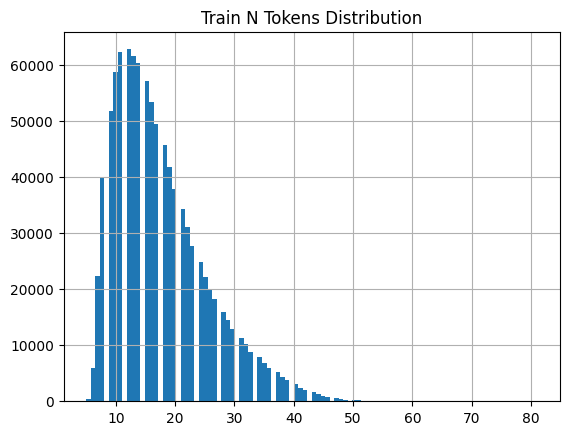

0.95 Quantile of N tokens: 33.0


In [78]:
# Here we want to figure out the max_length empirically

train_n_tokens = geo_processed_df["tokens"].apply(len)

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [79]:
SEQ_LEN = 50

In [80]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df["tokens"].to_list(),
    targets=geo_processed_df["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
    # trim_policy="first"
)

In [81]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: ['Піар', 'був', 'відповідним', ',', 'не', 'гребували', 'нічим', ',', 'нові', '«', 'сенсаційні', '»', 'звинувачення', 'зливою', 'проливалися', 'на', 'обивателів', 'і', 'керівництво', '.']
Text Ids: tensor([143935,     78,   7737,      2,     12, 129365,   5837,      2,    384,
            16,  99576,     17,   2370,  74638, 477698,      5, 118153,      8,
          1378,      3,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])
Target: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
    

In [82]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[ 32390,   1621,      2,     25,  26837,   2850,      5,   3160,      9,
            979,      9,    137,      3,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     4,    114,     12,    821,    443,  12293,   2174,  35496,      3,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [    82,    101,  27317,  39469,     12, 230256, 146891, 343767, 211

In [83]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_text_ids = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            predicted_label = inp_model(text)
            loss = criterion(predicted_label, label)
            if mode == "train":
                loss.mean().backward()
                optimizer.step()
                
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_text_ids.append(text.detach().cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
            
    all_losses = np.concatenate(all_losses)
    all_text_ids = np.concatenate(all_text_ids)
    all_predicted_label = np.concatenate(all_predicted_label)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets, all_text_ids

In [84]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=512,
    n_rnns=5,
    out_channels=1,
    average_type=None,
    bidirectional=True,
    dropout_rate=0.2
).to(global_device)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [85]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][0]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][0]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][1]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][1]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [86]:
# Create by Chat GPT: https://chat.openai.com/share/1ebda1cb-c708-4e2b-ac63-b89e26ea4f1c

def extract_token_sequences(tensor, text_ids):
    extracted_texts = []

    # Add a False column at the beginning and end for detecting regions at boundaries
    tensor = np.column_stack((np.zeros(tensor.shape[0], dtype=bool), tensor, np.zeros(tensor.shape[0], dtype=bool)))

    for i, sequence in enumerate(tensor):
        # Find indices where values change
        diff = np.where(sequence[:-1] != sequence[1:])[0]
        
        sequence_texts = []
        for j in range(0, len(diff), 2):
            start, end = diff[j], diff[j+1]-1
            # Extract the token ids for the region and join them with "_"
            sequence_texts.append("_".join(map(str, text_ids[i, start:end+1])))
        
        extracted_texts.append(sequence_texts)

    return extracted_texts

def apply_connected_regions_and_compute_metric(
    y_true,
    y_pred,
    texts,
    tresh=0.5
):
    real_tokens = extract_token_sequences(
        y_true[:,:,0] > 0.5,
        texts
    )
    pred_tokens = extract_token_sequences(
        y_pred[:,:,0] > tresh,
        texts
    )

    return comp_metric(real_tokens, pred_tokens)

In [87]:
n_epochs = 3

train_all_epoch_losses = []
valid_all_epoch_losses = []
valid_metrics = []

best_metric = {
    "f1": - np.inf,
}
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    _, train_epoch_losses, _, _ = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    # Skip Train Metric in order to speed up training loop
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets, valid_epoch_texts = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = apply_connected_regions_and_compute_metric(
        valid_epoch_targets, 
        valid_epoch_labels,
        valid_epoch_texts,
        tresh=0.5
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric["f1"])
    # 4. Save best model
    if valid_metric["f1"] > best_metric["f1"]:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate some stats  
    train_all_epoch_losses.append(train_epoch_losses)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_metrics.append(valid_metric)

Starting Epoch 1
Train phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [19:55<00:00, 21.12it/s]


Train BCE loss: 0.008344606
Valid phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:28<00:00, 112.72it/s]


Valid metric: {'precision': 0.8833882713683403, 'recall': 0.860331775491616, 'f1': 0.8717075901299566}
Valid BCE loss: 0.0058565596
Starting Epoch 2
Train phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [20:00<00:00, 21.03it/s]


Train BCE loss: 0.0048897383
Valid phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:28<00:00, 112.53it/s]


Valid metric: {'precision': 0.8825449110928112, 'recall': 0.8641094172278381, 'f1': 0.8732298731770617}
Valid BCE loss: 0.005590473
Starting Epoch 3
Train phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [19:44<00:00, 21.32it/s]


Train BCE loss: 0.0044785733
Valid phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:28<00:00, 109.33it/s]


Valid metric: {'precision': 0.8913670747874912, 'recall': 0.8533289534588565, 'f1': 0.8719333577444159}
Valid BCE loss: 0.0058920793
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.


> **TODO**: Here, metrics computation is not entirely correct. Can you figure out what the problem is and how to fix it?

Best Val Metrics: {'precision': 0.8825449110928112, 'recall': 0.8641094172278381, 'f1': 0.8732298731770617}


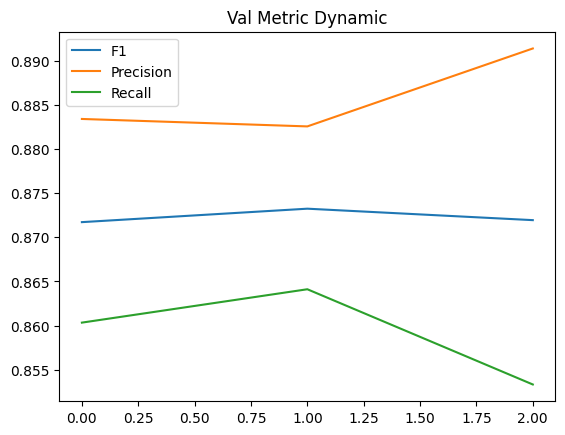

In [88]:
print("Best Val Metrics:", best_metric)
plt.title("Val Metric Dynamic")
plt.plot([el["f1"] for el in valid_metrics], label="F1")
plt.plot([el["precision"] for el in valid_metrics], label="Precision")
plt.plot([el["recall"] for el in valid_metrics], label="Recall")
plt.legend()
plt.show()

## Test on random Valid sample

In [89]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [90]:
valid_sample_index_with_locs = np.where(geo_dataset.iloc[folds_train_test_ids[0][1]].number_of_locations > 10)[0][0]

print("Sample text input:\n", geo_dataset.iloc[folds_train_test_ids[0][1]].iloc[valid_sample_index_with_locs].text)

text_idx, _ = valid_torch_dataset[valid_sample_index_with_locs]

with torch.inference_mode():
    test_sample_probs = torch.sigmoid(nn_model(text_idx[None,:].to(global_device))).detach().cpu().numpy()

predicted_ids = extract_token_sequences(
    test_sample_probs[:,:,0] > 0.5, 
    text_idx.numpy()[None,:]
)[0]

print("Our Prediction:")
pprint(set([" ".join(vocab.lookup_tokens([int(token) for token in el.split("_")])) for el in predicted_ids]))

Sample text input:
 Надзвичайний рівень переважатиме у Тернопільській, Хмельницькій, Вінницькій, Житомирській, Київській, Черкаській, Дніпропетрівській, Одеській, Миколаївській, Донецькій областях та в Криму.
Our Prediction:
{'Вінницькій',
 'Дніпропетрівській , Одеській , Миколаївській , Донецькій областях',
 'Житомирській',
 'Київській , Черкаській',
 'Криму',
 'Тернопільській',
 'Хмельницькій'}


> **TODO**: This case is very interesting. Maybe we need some post-processing.

<a id='Homework'></a>
# Homework

Theory (5 points):
- Complete theory questions in Google Form.
- Take a look at all links.
- Read and analyze all theory `TODO`s. In this lecture they are highly important.

Practice (10-15 points):
- First Option (Easier) - Apply [Sentence Classification](#Sentence_Classification) approach to [CommonLit - Evaluate Student Summaries
](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries):
    - Max Base Points: 10.
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyperparams.
    - Try pre-trained word embeddings (do not use embeddings trained with Transformer architectures; we will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair, etc.
    - Implement Cross-Validation.
    - Submit to Kaggle.
- Second Option (Harder) - Apply [Token Classification](#Token_Classification) approach to Location Detection task:
    - Max Base Points: 15.
    - Introduce fixes mentioned in `TODO`s.
    - Your model also has to handle russian language. Make sure to add `../data/mantis_analytics_location_detection/ru_geo_dataset.csv` (from https://www.kaggle.com/datasets/vladimirsydor/mantis-analytics-location-detection/data). Think about:
        - New Validation.
        - New Word Embeddings.
        - Possible usage of separate models.
    - Coming back to Lecture 3. F1 is the final production metric, but it hardly depends on the threshold. Maybe you can use some "soft" metric for model comparison? 
    - Is the ML model formalized correctly? In my approach, there are only two types of labels (O and LOC), but if you check [huggingface example](https://huggingface.co/learn/nlp-course/chapter7/2), there will be three labels (O; B-LOC and I-LOC).
    - Do we need additional post-processing?
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyperparams.
    - Try pre-trained word embeddings (do not use embeddings trained with Transformer architectures; we will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair, etc.
    - Implement Cross-Validation.
    - Upload the best model + inference code on some cloud storage. So we can run it on our hidden test set. Make sure to open it ONLY for lectors.
    - Additional points: the first best test score - 25 points, the second best test score - 15 points, the third best test score - 10 points.
- Third Option (Hardest). Do both the first and second options.
- Form will contain separate places for First and Second Options. Just put `-` for the Option which you have not chosen.